# Sim

## iThor

In [1]:
# Check conda version
!conda -V

conda 24.9.2


In [ ]:
# Check cuda version
!nvidia-smi

In [ ]:
!pip install --upgrade numpy scipy


In [ ]:
# Install matplotlib
%conda install -c conda-forge matplotlib -y

# Install torch
!pip3 install torch torchvision torchaudio

# Install transformers
!pip install 'transformers[torch]'


%pip install ultralytics

%pip install ai2thor

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

from PIL import Image
import requests

import time
from ultralytics import YOLO
import torch

from transformers import CLIPProcessor, CLIPModel

from ai2thor.controller import Controller

/home/sunzid/anaconda3/envs/ithor/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initiate scene

In [54]:
from ai2thor.controller import Controller


controller = Controller(

    agentMode="default",
    visibilityDistance=1.5,

    scene="FloorPlan1",
    # kitchens = [f"FloorPlan{i}" for i in range(1, 31)]
    # living_rooms = [f"FloorPlan{200 + i}" for i in range(1, 31)]
    # bedrooms = [f"FloorPlan{300 + i}" for i in range(1, 31)]
    # bathrooms = [f"FloorPlan{400 + i}" for i in range(1, 31)]

    # step sizes
    gridSize=0.25,
    snapToGrid=True,
    rotateStepDegrees=90,

    # image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=True,

    # camera properties
    width=300,
    height=300,
    fieldOfView=90
)

# controller.ithor_scenes(
#     include_kitchens=True,
#     include_living_rooms=True,
#     include_bedrooms=False,
#     include_bathrooms=False
# )


### Take Action

Movement parameters: MoveAhead, MoveBack, MoveLeft, MoveRight
Rotation parameters: RotateRight, RotateLeft
Camera rotation: LookUp, LookDown
Done: nothing

In [111]:
controller.step(
    action="Teleport",
    position=dict(x=2, y=0.9, z=0),
    rotation=dict(x=0, y=270, z=0),
)

controller.step(
    "MoveAhead",
    moveMagnitude=0.01
)

<ai2thor.server.Event at 0x75afc091a570
    .metadata["lastAction"] = MoveAhead
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [23]:
controller.stop()

In [56]:
print(f'agent position: {controller.last_event.metadata["agent"]["position"]}\n')

print(f'agnet rotation: {controller.last_event.metadata["agent"]["rotation"]}\n')

agent position: {'x': -1.25, 'y': 0.900999128818512, 'z': 1.25}

agnet rotation: {'x': -0.0, 'y': 0.0, 'z': 0.0}



### Sense environment

#### Event
```yaml
<ai2thor.server.Event
    .metadata: {...}

    .frame: {...}
    .cv2img: {...}

    .depth_frame: {...}

    .instance_segmentation_frame: {...}
    .instance_masks: {...}
    .instance_detections2D: {...}

    .color_to_object_id: {...}
    .object_id_to_color: {...}
/>
```

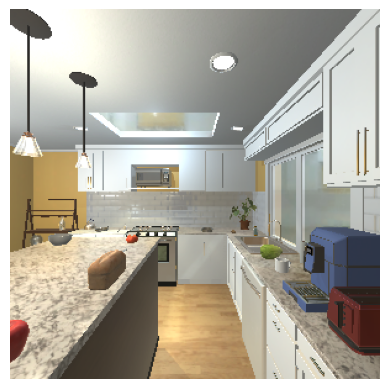

In [5]:
# event = controller.step("MoveAhead")
# event = controller.step("MoveLeft")
event = controller.step("RotateLeft")
event = controller.step("MoveAhead", moveMagnitude=0.1)
# 

plt.imshow(np.array(event.frame))
plt.axis(False);

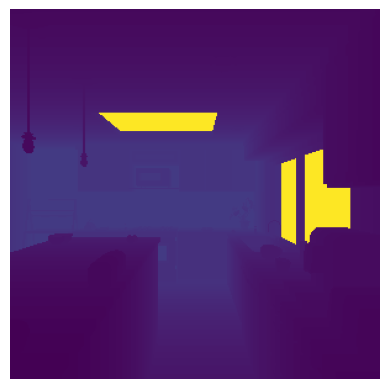

In [38]:
plt.imshow(np.array(event.depth_frame))
plt.axis(False);

In [27]:
plt.imshow(np.array(controller.last_event.frame))
plt.axis(False);

In [30]:
plt.imshow(np.array(controller.last_event.depth_frame))
plt.axis(False);

In [31]:
plt.imshow(np.array(controller.last_event.instance_segmentation_frame))
plt.axis(False);

#### Metadata
```yaml
{
    "errorMessage": {...}
    "lastActionSuccess": {...}
    "actionReturn": {...}
    "lastAction": {...}

    "sceneName": {...}
    "sceneBounds": {...}

    "agent": {...}
    "objects": {...}

    "fov": {...}
    "screenWidth": {...}
    "screenHeight": {...}
    {...}
}
```

In [12]:
print(f'error message: {controller.last_event.metadata["errorMessage"]}\n')
print(f'last action success: {controller.last_event.metadata["lastActionSuccess"]}\n')
print(f'action return: {controller.last_event.metadata["actionReturn"]}\n')
print(f'last action: {controller.last_event.metadata["lastAction"]}\n')
print(f'scene name: {controller.last_event.metadata["sceneName"]}\n')
print(f'scene bounds: {controller.last_event.metadata["sceneBounds"]}\n')
print(f'agent: {controller.last_event.metadata["agent"]}\n')
print(f'all objects in the scene: {controller.last_event.metadata["objects"]}\n')
print(f'fov: {controller.last_event.metadata["fov"]}\n')
print(f'screen width: {controller.last_event.metadata["screenWidth"]}\n')
print(f'screen height: {controller.last_event.metadata["screenHeight"]}\n')

error message: StandardIslandHeight is blocking Agent 0 from moving by (0.2500, 0.0000, 0.0000).

last action success: False

action return: None

last action: MoveAhead

scene name: FloorPlan1_physics

scene bounds: {'cornerPoints': [[2.474299907684326, 2.5999999046325684, 2.5621533393859863], [2.474299907684326, 2.5999999046325684, -2.9326725006103516], [2.474299907684326, -0.10000002384185791, 2.5621533393859863], [2.474299907684326, -0.10000002384185791, -2.9326725006103516], [-2.500056743621826, 2.5999999046325684, 2.5621533393859863], [-2.500056743621826, 2.5999999046325684, -2.9326725006103516], [-2.500056743621826, -0.10000002384185791, 2.5621533393859863], [-2.500056743621826, -0.10000002384185791, -2.9326725006103516]], 'center': {'x': -0.01287841796875, 'y': 1.2499998807907104, 'z': -0.18525958061218262}, 'size': {'x': 4.974356651306152, 'y': 2.6999998092651367, 'z': 5.494825839996338}}

agent: {'name': 'agent', 'position': {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}, 'rot

#### Agent metadata
```yaml
{
    cameraHorizon: {...},
    isStanding: {...},
    position: {...},
    rotation: {...},
    {...}
}
```

In [21]:
# controller.last_event contains the metadata of the last event
print(f'cameraHorizon: {controller.last_event.metadata["agent"]["cameraHorizon"]}\n')

print(f'is standing: {controller.last_event.metadata["agent"]["isStanding"]}\n')

print(f'agent position: {controller.last_event.metadata["agent"]["position"]}\n')

print(f'agnet rotation: {controller.last_event.metadata["agent"]["rotation"]}\n')

cameraHorizon: 0.0

is standing: True

agent position: {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}

agnet rotation: {'x': -0.0, 'y': 270.0, 'z': 0.0}



#### Object metadata
```yaml
{
    "objectId": {...},
    "objectType": {...},
    "name": {...},

    "distance": {...},
    "visible": {...},

    "position": {...},
    "rotation": {...},

    "axisAlignedBoundingBox": {...},
    "objectOrientedBoundingBox": {...},

    "mass": {...},
    "salientMaterials": {...},

    "parentReceptacles": {...},
    "receptacle": {...},
    "receptacleObjectIds": {...},

    "ObjectTemperature": {...},
    "canChangeTempToHot": {...},
    "canChangeTempToCold": {...},

    "moveable": {...},
    "isMoving": {...},

    "pickupable": {...},
    "isPickedUp": {...},

    {...Object State Changes...}
}
```

In [110]:
event.metadata["objects"]

[{'name': 'Apple_3fef4551',
  'position': {'x': -0.46516576409339905,
   'y': 1.151225209236145,
   'z': 0.47580063343048096},
  'rotation': {'x': 0.17450670897960663,
   'y': 5.203456021263264e-05,
   'z': 0.03407910093665123},
  'visible': False,
  'isInteractable': False,
  'receptacle': False,
  'toggleable': False,
  'isToggled': False,
  'breakable': False,
  'isBroken': False,
  'canFillWithLiquid': False,
  'isFilledWithLiquid': False,
  'fillLiquid': None,
  'dirtyable': False,
  'isDirty': False,
  'canBeUsedUp': False,
  'isUsedUp': False,
  'cookable': False,
  'isCooked': False,
  'temperature': 'RoomTemp',
  'isHeatSource': False,
  'isColdSource': False,
  'sliceable': True,
  'isSliced': False,
  'openable': False,
  'isOpen': False,
  'openness': 0.0,
  'pickupable': True,
  'isPickedUp': False,
  'moveable': False,
  'mass': 0.20000000298023224,
  'salientMaterials': ['Food'],
  'receptacleObjectIds': None,
  'distance': 0.7895858287811279,
  'objectType': 'Apple',
  

In [58]:
event.metadata["objects"][0]

{'name': 'Apple_3fef4551',
 'position': {'x': -0.46516576409339905,
  'y': 1.151225209236145,
  'z': 0.47580063343048096},
 'rotation': {'x': 0.17450670897960663,
  'y': 5.203456021263264e-05,
  'z': 0.03407910093665123},
 'visible': False,
 'isInteractable': False,
 'receptacle': False,
 'toggleable': False,
 'isToggled': False,
 'breakable': False,
 'isBroken': False,
 'canFillWithLiquid': False,
 'isFilledWithLiquid': False,
 'fillLiquid': None,
 'dirtyable': False,
 'isDirty': False,
 'canBeUsedUp': False,
 'isUsedUp': False,
 'cookable': False,
 'isCooked': False,
 'temperature': 'RoomTemp',
 'isHeatSource': False,
 'isColdSource': False,
 'sliceable': True,
 'isSliced': False,
 'openable': False,
 'isOpen': False,
 'openness': 0.0,
 'pickupable': True,
 'isPickedUp': False,
 'moveable': False,
 'mass': 0.20000000298023224,
 'salientMaterials': ['Food'],
 'receptacleObjectIds': None,
 'distance': 1.634577751159668,
 'objectType': 'Apple',
 'objectId': 'Apple|-00.47|+01.15|+00.48',

In [ ]:
print(f'all objects in the scene: {controller.last_event.metadata["objects"]}\n')

print(f'object id: {controller.last_event.metadata["objects"][0]["objectId"]}\n')
print(f'object type: {controller.last_event.metadata["objects"][0]["objectType"]}\n')
print(f'name: {controller.last_event.metadata["objects"][0]["name"]}\n')

print(f'distance: {controller.last_event.metadata["objects"][0]["distance"]}\n')
print(f'visible: {controller.last_event.metadata["objects"][0]["visible"]}\n')

print(f'position: {controller.last_event.metadata["objects"][0]["position"]}\n')
print(f'rotation: {controller.last_event.metadata["objects"][0]["rotation"]}\n')

print(f'axis aligned bounding box: {controller.last_event.metadata["objects"][0]["axisAlignedBoundingBox"]}\n')
print(f'object oriented bounding box: {controller.last_event.metadata["objects"][0]["objectOrientedBoundingBox"]}\n')

print(f'mass: {controller.last_event.metadata["objects"][0]["mass"]}\n')
print(f'salient materials: {controller.last_event.metadata["objects"][0]["salientMaterials"]}\n')

print(f'parent receptacles: {controller.last_event.metadata["objects"][0]["parentReceptacles"]}\n')
print(f'receptacle: {controller.last_event.metadata["objects"][0]["receptacle"]}\n')
print(f'receptacle object ids: {controller.last_event.metadata["objects"][0]["receptacleObjectIds"]}\n')

if "ObjectTemperature" in controller.last_event.metadata["objects"][0]:
	print(f'object temperature: {controller.last_event.metadata["objects"][0]["ObjectTemperature"]}\n')
else:
	print('object temperature: N/A\n')

if "canChangeTempToHot" in controller.last_event.metadata["objects"][0]:
	print(f'can change temp to hot: {controller.last_event.metadata["objects"][0]["canChangeTempToHot"]}\n')
else:
	print('can change temp to hot: N/A\n')

if "canChangeTempToCold" in controller.last_event.metadata["objects"][0]:
	print(f'can change temp to cold: {controller.last_event.metadata["objects"][0]["canChangeTempToCold"]}\n')
else:
	print('can change temp to cold: N/A\n')

print(f'moveable: {controller.last_event.metadata["objects"][0]["moveable"]}\n')
print(f'is moving: {controller.last_event.metadata["objects"][0]["isMoving"]}\n')

print(f'pickupable: {controller.last_event.metadata["objects"][0]["pickupable"]}\n')
print(f'is picked up: {controller.last_event.metadata["objects"][0]["isPickedUp"]}\n')

all objects in the scene: [{'name': 'Apple_3fef4551', 'position': {'x': -0.46516576409339905, 'y': 1.151225209236145, 'z': 0.47580063343048096}, 'rotation': {'x': 0.17450670897960663, 'y': 5.203456021263264e-05, 'z': 0.03407910093665123}, 'visible': False, 'isInteractable': False, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': True, 'isSliced': False, 'openable': False, 'isOpen': False, 'openness': 0.0, 'pickupable': True, 'isPickedUp': False, 'moveable': False, 'mass': 0.20000000298023224, 'salientMaterials': ['Food'], 'receptacleObjectIds': None, 'distance': 1.634577751159668, 'objectType': 'Apple', 'objectId': 'Apple|-00.47|+01.15|+00.48', 'assetId': 'App

In [60]:
# Get object in specific coordinate of frame

query = controller.step(
    action="GetObjectInFrame",
    x=0.64,
    y=0.40,
    checkVisible=False
)

object_id = query.metadata["actionReturn"]
object_id

##### Get objects in view

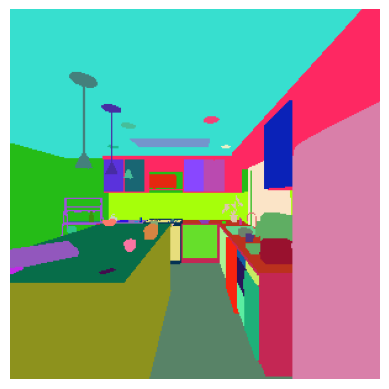

In [61]:
plt.imshow(np.array(controller.last_event.instance_segmentation_frame))
plt.axis(False);

In [62]:
segmentedColors = controller.last_event.instance_segmentation_frame
uniqueColors = np.unique(segmentedColors.reshape(-1, segmentedColors.shape[2]), axis=0)

objects_in_view = set()

for color in uniqueColors:
    color_tuple = tuple(int(c) for c in color)
    if color_tuple in event.color_to_object_id:
        objects_in_view.add(event.color_to_object_id[color_tuple])

# Print each object with coordinates converted to float values
for obj in objects_in_view:
    # Assuming the object string is formatted as "Name|x|y|z"
    parts = obj.split('|')
    if len(parts) == 4:
        name, x, y, z = parts
        try:
            # Convert string values to floats
            x_val = float(x)
            y_val = float(y)
            z_val = float(z)
        except ValueError:
            print(f"Error converting coordinates for: {obj}")
            continue
        
        # When converting to float, positive values will not display a '+'
        print(f"{name}, x: {x_val}, y: {y_val}, z: {z_val}")
    else:
        # If the format is unexpected, just print the raw string
        print(obj)


Drawer, x: -1.56, y: 0.33, z: -0.2
PepperShaker, x: 0.3, y: 0.9, z: -2.47
Spatula, x: 0.38, y: 0.91, z: -2.33
StoveBurner, x: -0.04, y: 0.92, z: -2.58
Cabinet, x: -0.73, y: 2.02, z: -2.46
Book, x: 0.15, y: 1.1, z: 0.62
CeilingLight, x: -1.2, y: 2.5, z: -0.3
Apple, x: -0.47, y: 1.15, z: 0.48
Window, x: -0.54, y: 2.595, z: -1.5
Toaster, x: -1.84, y: 0.9, z: 0.13
Bowl, x: 0.27, y: 1.1, z: -0.75
CeilingLight, x: -1.6, y: 2.5, z: -1.6
LightFixture1, x: -0.09999999, y: 2.5, z: 0.5
Cabinet, x: 0.68, y: 2.02, z: -2.46
Pan, x: 0.72, y: 0.9, z: -2.42
Cabinet, x: -1.69, y: 2.02, z: -2.46
Dishwasher, x: -1.55, y: 0.448, z: -0.718
Fridge, x: -2.1, y: 0.0, z: 1.07
HousePlant, x: -1.95, y: 0.89, z: -2.52
Pot, x: -1.22, y: 0.9, z: -2.36
Stove, x: 0.0, y: 0.0, z: 0.0
Cabinet, x: -1.55, y: 0.5, z: 0.38
StoveBurner, x: -0.47, y: 0.92, z: -2.58
StoveKnob, x: -0.48, y: 0.88, z: -2.19
Vase, x: 1.99, y: 0.56, z: -2.49
SoapBottle, x: -1.99, y: 0.9, z: -2.03
CounterTop, x: -1.87, y: 0.95, z: -1.21
Bottle, x: 1

In [64]:
event.color_to_object_id

{(231, 222, 124): 'Stove|0|0|0',
 (58, 170, 253): 'Stove',
 (150, 184, 112): 'Drawer|+00.95|+00.83|-02.20',
 (155, 30, 210): 'Drawer',
 (41, 19, 89): 'Drawer|-01.56|+00.66|-00.20',
 (25, 102, 115): 'Cabinet|+00.68|+02.02|-02.46',
 (210, 149, 89): 'Cabinet',
 (167, 137, 91): 'StoveBurner|-00.04|+00.92|-02.37',
 (156, 249, 101): 'StoveBurner',
 (10, 34, 184): 'Cabinet|-01.85|+02.02|+00.38',
 (186, 74, 176): 'Cabinet|-01.69|+02.02|-02.46',
 (243, 193, 185): 'StoveKnob|-00.48|+00.88|-02.19',
 (106, 252, 95): 'StoveKnob',
 (101, 210, 141): 'Sink|-01.90|+00.97|-01.50',
 (30, 181, 88): 'Sink',
 (90, 50, 220): 'Cabinet|+00.72|+02.02|-02.46',
 (170, 242, 149): 'Cabinet|-01.55|+00.50|-01.97',
 (81, 141, 199): 'Cabinet|+00.68|+00.50|-02.20',
 (19, 155, 196): 'Drawer|+00.95|+00.22|-02.20',
 (135, 98, 46): 'Drawer|+00.95|+00.71|-02.20',
 (80, 55, 124): 'Mug|-01.76|+00.90|-00.62',
 (8, 94, 186): 'Mug',
 (63, 150, 104): 'StoveBurner|-00.47|+00.92|-02.58',
 (91, 237, 161): 'Drawer|-01.56|+00.33|-00.20

In [65]:
def get_objects_in_view(event):
    segmentation = event.instance_segmentation_frame  # Expected shape: (H, W, 3)
    
    # Get unique colors
    # Reshape the image to (num_pixels, 3) and find unique rows.
    unique_colors = np.unique(segmentation.reshape(-1, segmentation.shape[2]), axis=0)
    
    objects_in_view = set()
    
    for color in unique_colors:
        color_tuple = tuple(int(c) for c in color)
        if color_tuple in event.color_to_object_id:
            objects_in_view.add(event.color_to_object_id[color_tuple])
    
    return list(objects_in_view)


In [66]:
get_objects_in_view(event)

['Drawer|-01.56|+00.33|-00.20',
 'PepperShaker|+00.30|+00.90|-02.47',
 'Spatula|+00.38|+00.91|-02.33',
 'StoveBurner|-00.04|+00.92|-02.58',
 'Cabinet|-00.73|+02.02|-02.46',
 'Book|+00.15|+01.10|+00.62',
 'CeilingLight|-1.2|2.5|-0.3',
 'Apple|-00.47|+01.15|+00.48',
 'Window|-0.54|2.595|-1.5',
 'Toaster|-01.84|+00.90|+00.13',
 'Bowl|+00.27|+01.10|-00.75',
 'CeilingLight|-1.6|2.5|-1.6',
 'LightFixture1|-0.09999999|2.5|0.5',
 'Cabinet|+00.68|+02.02|-02.46',
 'Pan|+00.72|+00.90|-02.42',
 'Cabinet|-01.69|+02.02|-02.46',
 'Dishwasher|-1.55|0.448|-0.718',
 'Fridge|-02.10|+00.00|+01.07',
 'HousePlant|-01.95|+00.89|-02.52',
 'Pot|-01.22|+00.90|-02.36',
 'Stove|0|0|0',
 'Cabinet|-01.55|+00.50|+00.38',
 'StoveBurner|-00.47|+00.92|-02.58',
 'StoveKnob|-00.48|+00.88|-02.19',
 'Vase|+01.99|+00.56|-02.49',
 'SoapBottle|-01.99|+00.90|-02.03',
 'CounterTop|-01.87|+00.95|-01.21',
 'Bottle|+01.54|+00.89|-02.54',
 'CounterTop|+00.69|+00.95|-02.48',
 'Lettuce|-01.81|+00.97|-00.94',
 'ShelvingUnit|+01.75|+00

In [67]:
query = controller.step(
    action="GetObjectInFrame",
    x=0.5,
    y=0.5,
    checkVisible=False
)

object_id = query.metadata["actionReturn"]

In [68]:
query

<ai2thor.server.Event at 0x76ae1f1e68d0
    .metadata["lastAction"] = GetObjectInFrame
    .metadata["lastActionSuccess"] = False
    .metadata["errorMessage"] = "InvalidOperationException: no sim objects found at (0.5,0.5). trace:   at UnityStandardAssets.Characters.FirstPerson.BaseFPSAgentController.screenToWorldTarget (System.Single x, System.Single y, SimObjPhysics& target, UnityEngine.RaycastHit& hit, System.Boolean forceAction, System.Boolean checkVisible) [0x000d1] in <40d6a6c54fa349fab67f7470c3432f83>:0    at UnityStandardAssets.Characters.FirstPerson.BaseFPSAgentController.screenToWorldTarget (System.Single x, System.Single y, SimObjPhysics& target, System.Boolean forceAction, System.Boolean checkVisible) [0x00008] in <40d6a6c54fa349fab67f7470c3432f83>:0    at UnityStandardAssets.Characters.FirstPerson.BaseFPSAgentController.GetObjectInFrame (System.Single x, System.Single y, System.Boolean checkVisible) [0x00002] in <40d6a6c54fa349fab67f7470c3432f83>:0    at (wrapper managed-

# Process Sensory Inputs

## Vision branch

### Literature

### Object detection

#### YOLO

##### Compare YOLOv8 Models

In [5]:
import time
from ultralytics import YOLO


In [16]:
# Provide the image path for inference.
img_path = np.array(controller.last_event.frame)

In [9]:
model8s = YOLO("models/YOLO/yolov8s.pt")

In [10]:

results = model8s(np.array(controller.last_event.frame))
results[0].show()



0: 640x640 1 sports ball, 1 cup, 1 bowl, 1 potted plant, 1 microwave, 1 oven, 1 sink, 13.3ms
Speed: 2.3ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Opening in existing browser session.


In [11]:
results = model8s(np.array(controller.last_event.frame))
results[0].show()
for box in results[0].boxes:
    x, y, w, h = box.xywh[0]
    confidence = box.conf[0]
    if confidence > 0.5:
        class_name = model8s.names[int(box.cls[0].item())]
        print(f"{class_name} at ({x:.2f}, {y:.2f}) with confidence {confidence:.2f}")





0: 640x640 1 sports ball, 1 cup, 1 bowl, 1 potted plant, 1 microwave, 1 oven, 1 sink, 13.4ms
Speed: 17.8ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
oven at (118.67, 196.66) with confidence 0.85
potted plant at (186.06, 163.65) with confidence 0.74


Opening in existing browser session.


In [ ]:


# ----------------------------
# Step 1: Build and Clean Unique Object Names from the Scene
# ----------------------------
# Get the list of objects from the scene metadata
objects = controller.last_event.metadata["objects"]

# Dictionary to hold unique objects keyed by object name.
# This assumes that the "name" field uniquely identifies an object.
unique_objects = {}
for obj in objects:
    name = obj.get('name')
    # Use the axisAlignedBoundingBox center if available, else use the position.
    center_info = obj.get('axisAlignedBoundingBox', {}).get('center', obj.get('position'))
    # Ensure that center_info exists and contains both x and y values.
    if center_info is not None and 'x' in center_info and 'y' in center_info:
        if name not in unique_objects:
            unique_objects[name] = (center_info['x'], center_info['y'])

# Clean object names by removing everything after (and including) the underscore.
# For example, "Apple_3fef4551" becomes "Apple".
cleaned_class_names = [name.split('_')[0] for name in unique_objects.keys()]
print("Cleaned unique object names (class_names):")
print(cleaned_class_names)

# ----------------------------
# Step 2: Load YOLOv8 Models
# ----------------------------
model8n = YOLO("models/YOLO/yolov8n.pt")
model8s = YOLO("models/YOLO/yolov8s.pt")
model8m = YOLO("models/YOLO/yolov8m.pt")
model8l = YOLO("models/YOLO/yolov8l.pt")
model8x = YOLO("models/YOLO/yolov8x.pt")

# Pack the models in a list for easy iteration.
models = [
    ("YOLOv8n", model8n),
    ("YOLOv8s", model8s),
    ("YOLOv8m", model8m),
    ("YOLOv8l", model8l),
    ("YOLOv8x", model8x)
]

# ----------------------------
# Step 3: Run Inference on an Image and Measure Detection Time
# ----------------------------
for model_name, model in models:
    print(f"\n--- Detections using {model_name} ---")
    start_time = time.time()  # Start timer
    
    results = model(img_path)  # Run inference
    
    end_time = time.time()  # End timer
    detection_time = end_time - start_time
    print(f"Detection time for {model_name}: {detection_time:.3f} seconds")
    
    # Process and print each detection in a YOLO-like format.
    # Note: YOLO models output indices corresponding to their trained classes.
    # Here, we map the detected class index to our cleaned object names if possible.
    for result in results:
        for box in result.boxes:
            # Extract bounding box (xywh), confidence, and class index.
            x, y, w, h = box.xywh[0]
            confidence = box.conf[0]
            class_index = int(box.cls[0].item())
            
            # Map the class index to our cleaned unique object names.
            if class_index < len(cleaned_class_names):
                label = cleaned_class_names[class_index]
            else:
                label = "Unknown"
            
            print(f"Label: {label}, Confidence: {confidence:.2f}, BBox: ({x:.1f}, {y:.1f}, {w:.1f}, {h:.1f})")


Cleaned unique object names (class_names):
['Apple', 'Book', 'Bottle', 'Bowl', 'Bread', 'ButterKnife', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'Cabinet', 'CoffeeMachine', 'CounterTop', 'CounterTop', 'CounterTop', 'CreditCard', 'Cup', 'DishSponge', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Drawer', 'Egg', 'Faucet', 'Floor', 'Fork', 'Fridge', 'GarbageCan', 'HousePlant', 'Kettle', 'Knife', 'Lettuce', 'LightSwitch', 'Microwave', 'Mug', 'Pan', 'PaperTowelRoll', 'PepperShaker', 'Plate', 'Pot', 'Potato', 'SaltShaker', 'Shelf', 'Shelf', 'Shelf', 'ShelvingUnit', 'Sink', 'SinkBasin', 'SoapBottle', 'Spatula', 'Spoon', 'Statue', 'Stool', 'Stool', 'StoveBurner', 'StoveBurner', 'StoveBurner', 'StoveBurner', 'StoveKnob', 'StoveKnob', 'StoveKnob', 'StoveKnob', 'Toaster', 'Tomato', 'Vase', 'Vase', 'Window', 'WineBottle']

--- Detections using YOLOv8n ---

0: 640x640 1 bowl, 1 chair, 1 potted plant, 1 dining table, 1 

##### YOLO object extraction

###### Get unique objects in the environment

In [13]:
# Extract the list of objects from the last event metadata.
objects = controller.last_event.metadata.get("objects", [])

# Use a set comprehension to extract unique object types.
unique_object_types = list(set([obj["objectType"] for obj in objects if "objectType" in obj]))

unique_object_types

['CounterTop',
 'Fridge',
 'Kettle',
 'CreditCard',
 'Shelf',
 'Microwave',
 'Floor',
 'PaperTowelRoll',
 'Statue',
 'PepperShaker',
 'Window',
 'Vase',
 'Drawer',
 'SoapBottle',
 'LightSwitch',
 'Fork',
 'Spoon',
 'Stool',
 'Lettuce',
 'StoveBurner',
 'Potato',
 'SinkBasin',
 'ShelvingUnit',
 'Spatula',
 'Mug',
 'WineBottle',
 'Egg',
 'SaltShaker',
 'Knife',
 'Tomato',
 'Bowl',
 'DishSponge',
 'Plate',
 'GarbageCan',
 'Pot',
 'Book',
 'Bread',
 'ButterKnife',
 'Sink',
 'Pan',
 'Bottle',
 'HousePlant',
 'StoveKnob',
 'CoffeeMachine',
 'Toaster',
 'Apple',
 'Cup',
 'Cabinet',
 'Faucet']

###### Run yolov8

In [68]:
results = model8l(np.array(controller.last_event.frame))
results[0].show()


0: 640x640 1 umbrella, 2 bottles, 2 cups, 1 bowl, 2 chairs, 1 potted plant, 1 dining table, 2 microwaves, 1 oven, 1 sink, 2 refrigerators, 37.7ms
Speed: 1.3ms preprocess, 37.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Opening in existing browser session.


In [70]:
for box in results[0].boxes:
    print(box)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([56.], device='cuda:0')
conf: tensor([0.8674], device='cuda:0')
data: tensor([[  9.7792, 153.1205,  51.1481, 187.7874,   0.8674,  56.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (300, 300)
shape: torch.Size([1, 6])
xywh: tensor([[ 30.4636, 170.4539,  41.3689,  34.6668]], device='cuda:0')
xywhn: tensor([[0.1015, 0.5682, 0.1379, 0.1156]], device='cuda:0')
xyxy: tensor([[  9.7792, 153.1205,  51.1481, 187.7874]], device='cuda:0')
xyxyn: tensor([[0.0326, 0.5104, 0.1705, 0.6260]], device='cuda:0')
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([69.], device='cuda:0')
conf: tensor([0.8504], device='cuda:0')
data: tensor([[ 89.4174, 174.2673, 129.0046, 220.1738,   0.8504,  69.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (300, 300)
shape: torch.Size([1, 6])
xywh: tensor([[109.2110, 197.2205,  39.5871,  45.9065]], device='cuda:0')
xywhn: tensor([[0.3640, 0.6574, 0.1320, 

In [11]:
detected_names = set()

for result in results:
    for box in result.boxes:
        conf = box.conf.item()
        if conf > 0:
            class_index = int(box.cls.item())
            object_name = model8l.names[class_index]
            detected_names.add(object_name)

detected_names

{'bottle',
 'bowl',
 'chair',
 'clock',
 'cup',
 'microwave',
 'oven',
 'potted plant',
 'sink',
 'umbrella',
 'vase'}

#### CLIP

In [218]:
clipModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clipProcessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [219]:
labels=["kitchen",
        "living room",
        "bed room",
        "bathroom"]

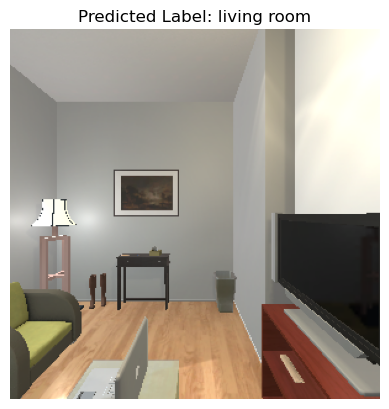

In [220]:
inputs = clipProcessor(labels, images=np.array(controller.last_event.frame), return_tensors="pt", padding=True)

outputs = clipModel(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

hiProbLabel = labels[torch.argmax(probs).item()]

plt.imshow(np.array(controller.last_event.frame));
plt.axis(False);
plt.title("Predicted Label: " + hiProbLabel);

### Visual mapping

#### Demo mapping

In [24]:
import numpy as np

def get_global_object_coords(query_object_name, detections,
                             image_width=300, image_height=300,
                             h_fov=90, v_fov=90, camera_offset=(0, 0, 0)):
    """
    Get the 3D global coordinates of an object detected in the current frame.
    
    This function:
      1. Queries the agent's global position from controller.last_event.metadata["agent"]["position"].
      2. Searches for the object by name in the detections list (each detection must have 'name', 'midpoint', and 'avg_depth').
      3. Computes the object's 3D coordinates in the camera (or agent) frame using its bounding box midpoint and depth.
      4. Converts these coordinates to global coordinates by adding the agent's position.
    
    Parameters:
      query_object_name : str
          The name of the object to search for.
      detections : list of dict
          Each detection dictionary must include:
             - 'name': object name
             - 'midpoint': tuple (u, v) representing the bounding box center in pixel coordinates
             - 'avg_depth': the average depth (in meters) for that detection.
      image_width : int
          Width of the image in pixels (default: 300).
      image_height : int
          Height of the image in pixels (default: 300).
      h_fov : float
          Horizontal field of view in degrees (default: 90).
      v_fov : float
          Vertical field of view in degrees (default: 90).
      camera_offset : tuple of floats (x, y, z)
          Optional offset of the camera relative to the agent's reference point (default: (0, 0, 0)).
    
    Returns:
      numpy.ndarray or None:
          The object's global 3D coordinates [x, y, z] as a NumPy array, or None if the object is not found
          or has invalid depth information.
    """
    # Query the agent's global position.
    agent_position = controller.last_event.metadata["agent"]["position"]

    # Search through detections for the desired object.
    detection = None
    for det in detections:
        if det['name'] == query_object_name:
            detection = det
            break
    if detection is None:
        print(f"Object '{query_object_name}' not found in detections.")
        return None
    if detection.get('avg_depth') is None:
        print(f"No valid depth information for '{query_object_name}'.")
        return None

    # Extract pixel coordinates and depth.
    u, v = detection['midpoint']
    depth = detection['avg_depth']

    # Calculate the image center.
    center_u = image_width / 2.0
    center_v = image_height / 2.0

    # Determine angular resolution (degrees per pixel).
    angle_per_pixel_h = (h_fov / 2.0) / center_u
    angle_per_pixel_v = (v_fov / 2.0) / center_v

    # Calculate angular offsets (in degrees) from the center.
    theta_h_deg = (u - center_u) * angle_per_pixel_h
    theta_v_deg = (v - center_v) * angle_per_pixel_v

    # Convert angles to radians.
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute the object's 3D coordinates in the camera frame.
    # Assumption: camera's X axis points forward, Y axis points right, Z axis points downward.
    x_cam = depth * np.cos(theta_v) * np.cos(theta_h) + camera_offset[0]
    y_cam = depth * np.cos(theta_v) * np.sin(theta_h) + camera_offset[1]
    z_cam = depth * np.sin(theta_v) + camera_offset[2]
    object_cam_coords = np.array([x_cam, y_cam, z_cam])

    # Convert to global coordinates by adding the agent's global position.
    agent_global = np.array([agent_position['x'], agent_position['y'], agent_position['z']])
    object_global_coords = agent_global + object_cam_coords

    print(f"Global 3D coordinates for '{query_object_name}': {object_global_coords}")
    return object_global_coords

# --- Example usage ---
if __name__ == '__main__':
    # Example detections list.
    detections = [
        {
            'name': 'oven',
            'bbox': [101.28, 179.29, 108.58, 184.84],
            'confidence': 0.85,
            'avg_depth': 2.0,
            'midpoint': (105, 182)
        },
        # ... additional detections ...
    ]
    
    query_object_name = "oven"
    global_coords = get_global_object_coords(query_object_name, detections)


Global 3D coordinates for 'oven': [    0.91751     0.44065      1.5835]


In [25]:
import numpy as np

def pixel_to_3d(u, v, d, image_width, image_height, h_fov=90, v_fov=90, camera_offset=(0,0,0)):
    """
    Convert pixel coordinates (u, v) with a depth measurement to 3D coordinates in the camera frame.
    
    Parameters:
      u, v         : Pixel coordinates in the image.
      d            : Depth measurement (meters).
      image_width  : Width of the image in pixels.
      image_height : Height of the image in pixels.
      h_fov        : Horizontal field of view in degrees.
      v_fov        : Vertical field of view in degrees.
      camera_offset: Optional (x, y, z) offset of the camera relative to the robot's reference point.
    
    Returns:
      A numpy array with the 3D coordinates (x, y, z) in the camera coordinate frame.
    """
    # Compute the centers of the image.
    center_u = image_width / 2.0
    center_v = image_height / 2.0

    # Compute angular resolutions for horizontal and vertical directions.
    angle_per_pixel_h = (h_fov / 2.0) / center_u  # degrees per pixel horizontally
    angle_per_pixel_v = (v_fov / 2.0) / center_v   # degrees per pixel vertically

    # Calculate the angular offsets (in degrees) from the center.
    theta_h_deg = (u - center_u) * angle_per_pixel_h
    theta_v_deg = (v - center_v) * angle_per_pixel_v

    # Convert angles to radians.
    theta_h = np.deg2rad(theta_h_deg)
    theta_v = np.deg2rad(theta_v_deg)

    # Compute the 3D coordinates in the camera frame.
    x_cam = d * np.cos(theta_v) * np.cos(theta_h)
    y_cam = d * np.cos(theta_v) * np.sin(theta_h)
    z_cam = d * np.sin(theta_v)

    # Apply any camera offset.
    x_cam += camera_offset[0]
    y_cam += camera_offset[1]
    z_cam += camera_offset[2]

    return np.array([x_cam, y_cam, z_cam])


def get_object_3d_coords(query_object_name, detections, image_width=300, image_height=300, h_fov=90, v_fov=90):
    """
    Query a specific object by its name from the detections list and convert its midpoint 
    (with associated depth) to 3D coordinates using the pixel_to_3d function.

    Parameters:
      query_object_name : The name of the object to search for.
      detections        : A list of detection dictionaries.
      image_width       : The width of the image in pixels (default is 300).
      image_height      : The height of the image in pixels (default is 300).
      h_fov             : Horizontal field of view in degrees (default is 90).
      v_fov             : Vertical field of view in degrees (default is 90).

    Returns:
      A numpy array with the object's 3D coordinates (x, y, z) if found and valid;
      otherwise, returns None.
    """
    queried_detection = None
    # Search through the detections for the object.
    for detection in detections:
        if detection['name'] == query_object_name:
            queried_detection = detection
            break

    if queried_detection is None:
        print(f"Object '{query_object_name}' not found in detections.")
        return None

    # Extract the midpoint and average depth from the queried detection.
    midpoint = queried_detection['midpoint']  # (u, v)
    avg_depth = queried_detection['avg_depth']
    
    if avg_depth is None:
        print(f"No valid depth information for '{query_object_name}'.")
        return None

    # Compute the 3D coordinates using the midpoint and depth.
    object_3d_coords = pixel_to_3d(midpoint[0], midpoint[1], avg_depth,
                                   image_width, image_height,
                                   h_fov, v_fov)
    
    print(f"3D coordinates for '{query_object_name}': {object_3d_coords}")
    return object_3d_coords

# Example usage:
if __name__ == '__main__':
    # Assume that `detections` is already defined as in your previous code.
    # For example:
    # detections = [
    #     {'name': 'person', 'bbox': [101.28, 179.29, 108.58, 184.84],
    #      'confidence': 0.85, 'avg_depth': 2.0, 'midpoint': (105, 182)},
    #     ... (other detections) ...
    # ]
    query_object_name = "oven"  # Replace with the desired object name.
    coords = get_object_3d_coords(query_object_name, detections)


3D coordinates for 'oven': [     1.9175    -0.46035     0.33354]


#### Get detected objects

In [157]:
def get_objects_by_type(object_type_keyword):
    """
    Filters and returns scene objects whose 'objectType' field contains the given keyword.
    
    Parameters:
        object_type_keyword (str): The keyword to search for in the object type.
        
    Returns:
        list: A list of dictionaries representing objects whose 'objectType'
              includes the keyword (case-insensitive).
    """
    # Retrieve all objects from the scene metadata.
    all_objects = controller.last_event.metadata.get("objects", [])
    
    # Filter the objects using a list comprehension.
    filtered_objects = [
        obj for obj in all_objects
        if object_type_keyword.lower() in obj.get("objectType", "").lower()
    ]
    
    return filtered_objects

# Example usage:
if __name__ == "__main__":
    # Filter for objects whose type includes "fridge" (e.g., 'Fridge', 'Refrigerator', etc.)
    fridge_objects = get_objects_by_type("fridge")
    
    print("Filtered objects (matching 'fridge'):")
    for obj in fridge_objects:
        print(obj)


Filtered objects (matching 'fridge'):
{'name': 'Fridge_e92350c6', 'position': {'x': -2.0969998836517334, 'y': 0.0, 'z': 1.0720000267028809}, 'rotation': {'x': -0.0, 'y': 89.9999771118164, 'z': -0.0}, 'visible': True, 'isInteractable': True, 'receptacle': True, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': True, 'sliceable': False, 'isSliced': False, 'openable': True, 'isOpen': False, 'openness': 0.0, 'pickupable': False, 'isPickedUp': False, 'moveable': False, 'mass': 0.0, 'salientMaterials': None, 'receptacleObjectIds': ['Egg|-02.04|+00.81|+01.24'], 'distance': 1.6959929466247559, 'objectType': 'Fridge', 'objectId': 'Fridge|-02.10|+00.00|+01.07', 'assetId': 'Fridge_1', 'parentReceptacles': ['Floo

### Sentence Transformer

#### SentenceTransformer

In [ ]:
%pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
text_similarity_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:
import numpy as np
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer, util

# 1. Run YOLOv8 detection
# Assume model8x is your YOLO model and controller.last_event.frame is your input image.
results = model8x(np.array(controller.last_event.frame))
detected_names = set()

for result in results:
    for box in result.boxes:
        conf = box.conf.item()
        if conf > 0.1:
            class_index = int(box.cls.item())
            object_name = model.names[class_index]
            detected_names.add(object_name)

print("Detected objects:", detected_names)

# 2. Set up the sentence similarity model (using SentenceTransformer)
llm_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose a different model if desired

# The query sentence
query_sentence = "burning smell"

# Compute the embedding for the query sentence
query_embedding = llm_model.encode(query_sentence, convert_to_tensor=True)

# 3. Compute similarity for each detected object
similarities = {}
for name in detected_names:
    # Compute the embedding for the detected object name
    name_embedding = llm_model.encode(name, convert_to_tensor=True)
    # Calculate cosine similarity between the query and the object name
    similarity = util.cos_sim(query_embedding, name_embedding).item()
    similarities[name] = similarity

# 4. Display similarity scores
print("\nSimilarity Scores to 'burning smell':")
for name, sim in similarities.items():
    print(f"'{name}': {sim:.4f}")

# Optionally, if you want to filter out objects below a certain similarity threshold:
threshold = 0.3  # Adjust this value as needed
similar_objects = {name: sim for name, sim in similarities.items() if sim > threshold}
print("\nObjects with similarity above threshold:")
for name, sim in similar_objects.items():
    print(f"'{name}': {sim:.4f}")


### Segmentation

#### Clipseg

In [329]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests

processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

/home/sunzid/anaconda3/envs/ithor/lib/python3.13/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


torch.Size([1, 352, 352])


In [330]:

image = np.array(controller.last_event.frame)
texts = ["a chair"]
inputs = processor(text=texts, images=[image] * len(texts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 352, 352])


In [331]:
import cv2

torch.Size([1, 352, 352])


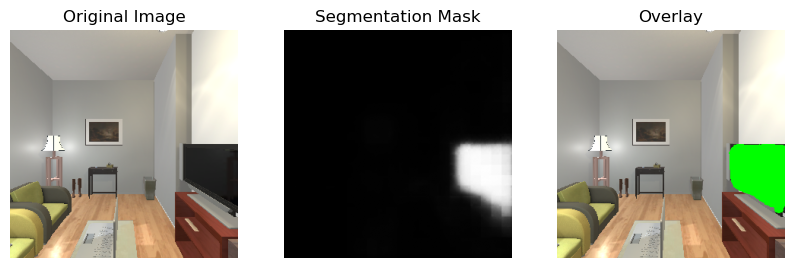

In [342]:

image = np.array(controller.last_event.frame)
texts = ["a TV"]
inputs = processor(text=texts, images=[image] * len(texts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

# Convert mask to numpy array (DETACH before .numpy())
mask = outputs.logits.squeeze().sigmoid().detach().cpu().numpy()  # Convert to probability map

# Normalize the mask for visualization
mask = (mask * 255).astype(np.uint8)

# Resize mask to match original image size
mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))  # Ensure correct dimensions

# Apply threshold to create a binary mask
_, binary_mask = cv2.threshold(mask_resized, 128, 255, cv2.THRESH_BINARY)

# Overlay mask on the original image
overlay = image.copy()
overlay[binary_mask > 128] = [0, 255, 0]  # Highlight the mask in green

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis(False);
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mask_resized, cmap="gray")
plt.axis(False);
plt.title("Segmentation Mask")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis(False);
plt.title("Overlay")

plt.axis(False);
plt.show()

In [343]:
# Get the depth map as a NumPy array
depth_map = np.array(controller.last_event.depth_frame)  # Shape: (H, W)

# Ensure the depth map has the same size as the image
depth_map_resized = cv2.resize(depth_map, (image.shape[1], image.shape[0]))

# Extract depth values where the mask is active (binary_mask > 128)
masked_depth_values = depth_map_resized[binary_mask > 128]

# Compute the average depth within the masked region
if masked_depth_values.size > 0:
    average_depth = np.mean(masked_depth_values)
else:
    average_depth = None  # No valid depth values in the mask

# Print result
print(f"Average Depth in Masked Region: {average_depth}")


Average Depth in Masked Region: 1.2981693744659424


In [345]:
# Get the coordinates of all pixels inside the mask
mask_indices = np.argwhere(binary_mask > 128)  # Get (y, x) positions

image_height, image_width = image.shape[:2]
print(f"Full Image Size: Width = {image_width}, Height = {image_height}")

# Compute the centroid (midpoint)
if mask_indices.size > 0:
    centroid_y, centroid_x = np.mean(mask_indices, axis=0).astype(int)
    print(f"Mask Midpoint (Centroid): ({centroid_x}, {centroid_y})")
else:
    centroid_x, centroid_y = None, None
    print("No valid mask region detected.")


Full Image Size: Width = 300, Height = 300
Mask Midpoint (Centroid): (266, 187)


#### Sam2 mask generation

In [ ]:
%pip install sam2

In [323]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

mask_generator = SAM2AutomaticMaskGenerator.from_pretrained("facebook/sam2-hiera-small", device="cuda")    


In [327]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [325]:
masks = mask_generator.generate(np.array(controller.last_event.frame))

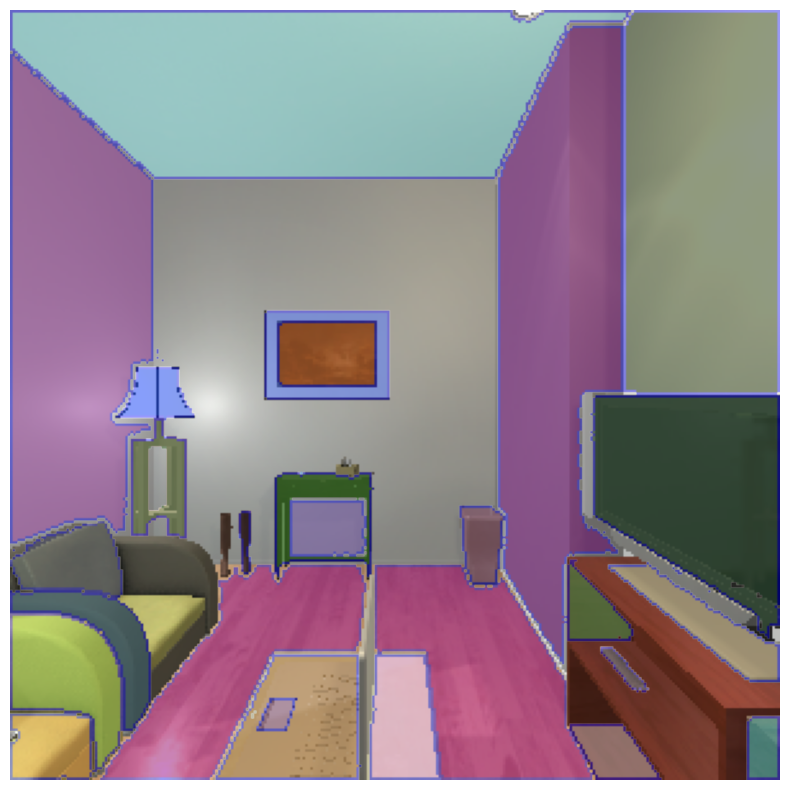

In [328]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(controller.last_event.frame))
show_anns(masks)
plt.axis(False);
plt.show()

#### Detr instance segmentation

In [ ]:
%pip install timm

In [6]:
import torch
import numpy as np
from transformers import DetrImageProcessor, DetrForSegmentation
from PIL import Image, ImageDraw, ImageFont
import requests

# Download an example image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Use the panoptic segmentation model
model_name = "facebook/detr-resnet-50-panoptic"
processor = DetrImageProcessor.from_pretrained(model_name)
model = DetrForSegmentation.from_pretrained(model_name)

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Specify target sizes as a list of tuples (height, width)
target_sizes = [tuple(image.size[::-1])]  # image.size returns (width, height)

# Post-process to get panoptic segmentation results
results = processor.post_process_panoptic_segmentation(outputs, target_sizes=target_sizes)[0]

# Extract segmentation map and segments info
segmentation = results["segmentation"]  # tensor with segment IDs per pixel
segments_info = results["segments_info"]  # list of dicts for each segment

# Prepare to draw results on the image
draw = ImageDraw.Draw(image)
try:
    font = ImageFont.truetype("arial.ttf", size=15)
except IOError:
    font = ImageFont.load_default()

# Loop over each segment to compute bounding boxes and labels
for segment in segments_info:
    seg_id = segment["id"]
    # Create a mask for this segment (instance)
    mask = segmentation == seg_id
    if mask.sum() == 0:
        continue

    # Compute bounding box coordinates from the mask
    mask_np = mask.cpu().numpy()
    ys, xs = np.where(mask_np)
    xmin, xmax = int(xs.min()), int(xs.max())
    ymin, ymax = int(ys.min()), int(ys.max())

    # Get label name using the category id if available
    category_id = segment.get("category_id")
    if category_id is not None:
        label = model.config.id2label.get(category_id, str(category_id))
    else:
        label = "N/A"

    # Prepare text label with score
    text = f"{label} ({segment.get('score', 1.0):.2f})"
    
    # Use font.getbbox() to compute text dimensions
    bbox = font.getbbox(text)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    text_size = (text_width, text_height)
    
    text_bg = [xmin, ymin - text_size[1], xmin + text_size[0], ymin]

    # Draw the bounding box and label on the image
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
    draw.rectangle(text_bg, fill="red")
    draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)

# Display the result
image.show()


Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Opening in existing browser session.


### Visual object embedding

#### CLIP Embeding

In [ ]:
from transformers import CLIPModel, CLIPProcessor

clipModel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clipProcessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [388]:
input_image = np.array(controller.last_event.frame)

# Preprocess the image
inputs = clipProcessor(images=input_image, return_tensors="pt")

with torch.no_grad():
    image_embeddings = clipModel.get_image_features(**inputs)

In [390]:
image_embeddings.shape

torch.Size([1, 512])

In [406]:
query = "A corridor with doors"  # Input Query

query_tokens = clipProcessor.tokenizer([query], return_tensors="pt")  # Tokenize Before Embeddings

with torch.no_grad():
  query_embeddings = clipModel.get_text_features(**query_tokens)
  
  
def calculate_similarity(query_embeddings, input_embeddings):
  similariries = query_embeddings @ input_embeddings.T
  return similariries
  
sim = calculate_similarity(query_embeddings, image_embeddings)

sim

tensor([[28.4528]])

## Olfaction Branch

### 2D-gas dispersion model for iThor

Calculate theta value

$$\begin{cases}
\theta=robotRot-(150-vizAng)*0.3 & \text{if } xCrd\lt 150\\
\theta=robotRot+(vizAng-150)*0.3 & \text{if } xCrd\gt 150\\
\end{cases}$$

In [22]:
depthFrame = controller.last_event.depth_frame
print(depthFrame.shape)

# print(depth(186.07, 163.66))
# Convert coordinates to integers
x_coord = 118.0 # for oven
y_coord = 197

# x_coord = 186.07 # for potted plant
# y_coord = 163.66

pointDepth = float(depthFrame[round(y_coord), round(x_coord)])
pointDepth = float(depthFrame[round(x_coord), round(y_coord)])
pointDepth



(300, 300)


2.714372158050537

In [10]:
def depth(x_coord: int, y_coord: int):
    fov = 90  # Horizontal field of view
    image_width = 300  # Image width in pixels
    center_x = image_width / 2.0
    angle_per_pixel = fov / image_width
    if x_coord < center_x:
        theta = (center_x - x_coord) * angle_per_pixel
    else:
        theta = (x_coord - center_x) * angle_per_pixel
    straightDepth = float(depthFrame[round(x_coord), round(y_coord)])
    hDepth = straightDepth #/ np.cos(theta)
    return hDepth


def hThetaCalc(x_coord: float):
    # Calculate the angle theta
    h_fov = 90  # Horizontal field of view
    image_width = 300  # Image width in pixels
    center_x = image_width / 2.0
    angle_per_pixel = h_fov / image_width
    robotRot = int(controller.last_event.metadata["agent"]["rotation"]["y"])
    if x_coord < center_x:
        theta = robotRot - (center_x - x_coord) * angle_per_pixel
    else:
        theta = robotRot + (x_coord - center_x) * angle_per_pixel
    return theta


def vThetaCalc(y_coord: float):
    # Calculate the angle theta
    v_fov = 90  # Horizontal field of view
    image_height = 300  # Image width in pixels
    center_y = image_height / 2.0
    angle_per_pixel = v_fov / image_height
    if y_coord < center_y:
        theta = (center_y - y_coord) * angle_per_pixel
    else:
        theta = (y_coord - center_y) * angle_per_pixel
    return theta


def getGlobalCoords(x_coord: int, y_coord: int, depth: float):
    # Calculate the global coordinates
    hTheta = hThetaCalc(x_coord)
    vTheta = vThetaCalc(y_coord)
    agent_x = controller.last_event.metadata["agent"]["position"]["x"]
    agent_y = controller.last_event.metadata["agent"]["position"]["y"]
    agent_z = controller.last_event.metadata["agent"]["position"]["z"]
    global_z = agent_z + depth * np.sin(np.radians(hTheta))
    global_x = agent_x + depth * np.cos(np.radians(hTheta))
    global_y = agent_y + depth * np.cos(np.radians(vTheta))
    return round(global_x,2), round(global_y,2), round(global_z,2)

depthFrame = controller.last_event.depth_frame

# house plant
x_coord = 186.07
y_coord = 163.66
pointDepth = float(depthFrame[round(x_coord), round(y_coord)])
global_x, global_y, global_z = getGlobalCoords(x_coord, y_coord, pointDepth)
print(f'x: {global_x}, y: {global_y}, z: {global_z}')


# microwave
x_coord = 118.14
y_coord = 197.17
pointDepth = float(depthFrame[round(x_coord), round(y_coord)])
global_x, global_y, global_z = getGlobalCoords(x_coord, y_coord, pointDepth)
print(f'x: {global_x}, y: {global_y}, z: {global_z}')

x: -4.37, y: 4.33, z: 0.61
x: -3.68, y: 3.53, z: 1.7


In [ ]:
# Get object centers
def get_objects_depth(objects, target_names):
    """
    Returns depth value at a given coordinate from the depth frame.
        
    Parameters:
        x, z (int): The pixel coordinates (x, z) to retrieve the depth value.
        
    Returns:
        int: The depth value at the specified pixel coordinates.
    """
                
    return np.array(centers)

# Example usage:
# Assume controller.last_event.metadata["objects"] holds the scene objects.
objects = controller.last_event.metadata["objects"]

# To get the centers of objects whose name includes either "Apple" or "Bread":
target_items = ["Toaster"]
object_centers = get_objects_centers(objects, target_items)
print("Centers of specified objects as a tensor:")
print(object_centers)


#### Probably good

In [42]:
import numpy as np
import math

def compute_object_coordinate_full_distance(
    robot_pos,
    robot_yaw_deg,
    pixel_coord,
    depth,
    image_width=300,
    image_height=300,
    fov_deg=90,
    camera_y_offset=0.4  # Subtract this from the y-coordinate after transformation
):
    """
    Computes the object's world coordinate assuming that the depth value is the
    full (Euclidean) distance from the camera to the object.
    
    Parameters:
      robot_pos: Robot position as a tuple/list or dict (if dict, keys: "x", "y", "z")
      robot_yaw_deg: Robot's yaw in degrees (rotation about the y-axis)
      pixel_coord: Tuple or list (u, v) of the object in the image
      depth: The measured Euclidean distance from the camera to the object
      image_width: Image width in pixels (default: 300)
      image_height: Image height in pixels (default: 300)
      fov_deg: Camera field of view in degrees (default: 90)
      camera_y_offset: Vertical offset (in world units) to adjust the camera’s position relative to the robot
      
    Returns:
      A NumPy array with the object's world coordinate [x, y, z].
    """
    # 1. Camera intrinsics
    cx = image_width / 2.0
    cy = image_height / 2.0
    f = (image_width / 2.0) / math.tan(math.radians(fov_deg / 2.0))
    
    # 2. Normalized image coordinates
    u, v = pixel_coord
    x_norm = (u - cx) / f
    y_norm = (v - cy) / f
    
    # 3. Construct the ray in the camera frame
    d = np.array([x_norm, y_norm, 1.0])
    norm_d = math.sqrt(x_norm**2 + y_norm**2 + 1)
    
    # 4. Scaling factor s so that s * ||d|| equals the measured depth
    s = depth / norm_d
    
    # Compute the camera-frame coordinates
    p_cam = s * d  # [x_cam, y_cam, z_cam]
    
    # 5. Rotate the camera coordinates into the world frame using the robot's yaw.
    theta = math.radians(robot_yaw_deg)
    R_yaw = np.array([
        [math.cos(theta), 0, math.sin(theta)],
        [0, 1, 0],
        [-math.sin(theta), 0, math.cos(theta)]
    ])
    p_rot = R_yaw.dot(p_cam)
    
    # 6. Convert robot_pos to an array
    if isinstance(robot_pos, dict):
        T_robot = np.array([robot_pos["x"], robot_pos["y"], robot_pos["z"]])
    else:
        T_robot = np.array(robot_pos)
    
    # Add the translation
    p_world_raw = p_rot + T_robot
    
    # 7. Adjust for the camera mounting offset in y
    p_world = np.copy(p_world_raw)
    p_world[1] -= camera_y_offset
    
    return p_world

# --- Example usage ---
if __name__ == '__main__':
    # Assumed inputs:
    robot_position = {"x": -1.0, "y": 0.901, "z": 1.25}
    robot_yaw = 180.0
    pixel_location = (118.14, 197.17)
    # pixel_location = (186.02, 163.66)
    depth_value = 1.9

    robot_position = controller.last_event.metadata["agent"]["position"]
    robot_yaw = controller.last_event.metadata["agent"]["rotation"]["y"]
    # object_name = "potted plant"
    
    # object_name = "refrigerator"

    
    # yolo_coords = extract_object_xy(results, object_name, yolov8l.names)

    # pixel_location = yolo_coords[0]

    depthFrame = controller.last_event.depth_frame

    depth_value = float(depthFrame[round(pixel_location[1]), round(pixel_location[0])])

    depth_value = 4

    obj_world_coord = compute_object_coordinate_full_distance(
        robot_pos=robot_position,
        robot_yaw_deg=robot_yaw,
        pixel_coord=pixel_location,
        depth=depth_value,
        image_width=300,
        image_height=300,
        fov_deg=90,
        camera_y_offset=0.4
    )
    
    print(f"Robot position: {robot_position}")
    print(f"Robot yaw: {robot_yaw}")
    print(f"Pixel location: {pixel_location}")
    print(f"Depth value: {depth_value}")
    
    print("Computed Object Coordinate (world frame):")
    print(obj_world_coord)


Robot position: {'x': -1.0, 'y': 0.900999128818512, 'z': 1.25}
Robot yaw: 180.0
Pixel location: (118.14, 197.17)
Depth value: 4
Computed Object Coordinate (world frame):
[   -0.20567       1.677     -2.4898]


#### Get gas field value using gas dispersion model

Scene Bounds (X-Z):
  X: -2.50 -> 2.47
  Z: -2.93 -> 2.56
Odor concentration at (x=1, z=1): 3.23


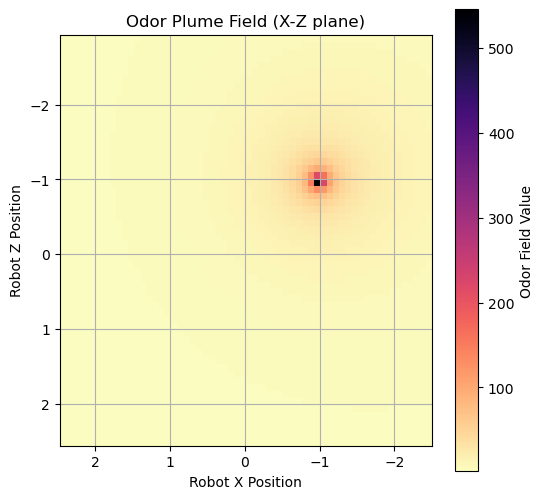

In [182]:
import math
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# ------------------------------------------------------------------
# 1. Re-implemented plume function using x and z coordinates
# ------------------------------------------------------------------
# Get object centers
def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)

def get_field_value(x, z, sources, q_s=2000, D=10, U=2, tau=1000, del_t=1, psi_deg=190*(math.pi/2)):
    """
    Computes the odor field value at a single (x, z) coordinate as the sum of contributions
    from one or more odor sources.

    Parameters:
        x, z       (float): Coordinates at which to evaluate the field.
        sources    (ndarray or list): A collection of source positions, where each source is [x_s, y_s, z_s].
        q_s        (float): Source strength.
        D          (float): Diffusion coefficient.
        U          (float): Advection velocity (set to 0 if no airflow).
        tau        (float): Time or scaling parameter.
        del_t      (float): Time step.
        psi_deg    (float): Angle in degrees for rotation (direction of advection; irrelevant if U==0).

    Returns:
        (float): The computed field value at the coordinate (x, z) as the sum of contributions
                 from all sources.
    """
    # Convert psi from degrees to radians
    psi = math.radians(psi_deg)
    
    # Compute lambda; if U == 0, lambda simplifies to sqrt(D*tau)
    lambd = math.sqrt((D * tau) / (1 + (tau * U**2) / (4 * D)))
    
    total = 0.0
    eps = 1e-6  # Small value to prevent division by zero
    
    # Loop over each source
    for source in sources:
        x_s, y_s, z_s = source  # Unpack the source coordinates; ignore y_s here.
        
        # Compute differences in x and z relative to the odor source
        delta_x = x - x_s
        delta_z = z - z_s
        
        # Euclidean distance in the X-Z plane
        r = math.sqrt(delta_x**2 + delta_z**2)
        
        # Compute the rotated z coordinate (this incorporates advection if U != 0)
        rotated_z = -delta_x * math.sin(psi) + delta_z * math.cos(psi)
        
        # Handle r == 0 case
        if r < eps:
            contribution = (q_s / (4 * math.pi * D * eps)) * math.exp(-rotated_z * U / (2 * D)) * math.exp(- (eps / lambd) * del_t)
        else:
            contribution = (q_s / (4 * math.pi * D * r)) * math.exp(-rotated_z * U / (2 * D)) * math.exp(- (r / lambd) * del_t)

        total += contribution
        
    return total

# Vectorize the field function (exclude sources so that it is not vectorized)
vectorized_field_value = np.vectorize(get_field_value, excluded=['sources'])


# ------------------------------------------------------------------
# 2. Extract scene bounds (using X and Z coordinates)
# ------------------------------------------------------------------
scene_bounds = controller.last_event.metadata["sceneBounds"]
corner_points = scene_bounds['cornerPoints']  # each point is [x, y, z]

# For the plume map we use X and Z (ignoring the Y values)
unique_xz_points = [(p[0], p[2]) for p in corner_points]
scene_polygon = Polygon(unique_xz_points)

# Get the bounding box: (min_x, min_z, max_x, max_z)
min_x, min_z, max_x, max_z = scene_polygon.bounds

print("Scene Bounds (X-Z):")
print(f"  X: {min_x:.2f} -> {max_x:.2f}")
print(f"  Z: {min_z:.2f} -> {max_z:.2f}")


# ------------------------------------------------------------------
# 3. Define the grid over the scene (in X and Z)
# ------------------------------------------------------------------
grid_steps = 60  # Increase for finer resolution
x_vals = np.linspace(min_x, max_x, grid_steps)
z_vals = np.linspace(min_z, max_z, grid_steps)
X, Z = np.meshgrid(x_vals, z_vals)


# ------------------------------------------------------------------
# 4. Define odor source(s) 
# ------------------------------------------------------------------
# Get the odor source positions from the scene objects. 
# (Assumes get_objects_centers returns a list of [x, y, z] for each target object.)
objects = controller.last_event.metadata["objects"]
odor_items = ["Microwave"]
odor_sources = get_objects_centers(objects, odor_items)  # e.g., [[x1, y1, z1], ...]
odor_sources = [[-1, 1, -1]]
# (Optional) Print one odor concentration value at a sample position (x=1, z=1)
sample_concentration = get_field_value(x=1, z=1, sources=odor_sources)
print(f'Odor concentration at (x=1, z=1): {sample_concentration:.2f}')


# ------------------------------------------------------------------
# 5. Evaluate the field on the grid
# ------------------------------------------------------------------
field = vectorized_field_value(X, Z, sources=odor_sources)


# ------------------------------------------------------------------
# 6. Plot the plume field map with correct orientation
# ------------------------------------------------------------------
plt.figure(figsize=(6, 6))
# Notice: we no longer transpose the field.
plt.imshow(field, origin='lower', cmap='magma_r', extent=[min_x, max_x, min_z, max_z])
plt.colorbar(label='Odor Field Value')
plt.xlabel('Robot X Position')
plt.ylabel('Robot Z Position')
plt.title('Odor Plume Field (X-Z plane)')

# Apply axis limits and inversion to match the trajectory map:
plt.xlim(min_x, max_x)
plt.ylim(max_z, min_z)  # Invert Z-axis if desired
plt.gca().invert_xaxis()  # Invert X-axis so negative X appears to the right

plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


0.08553114458728665


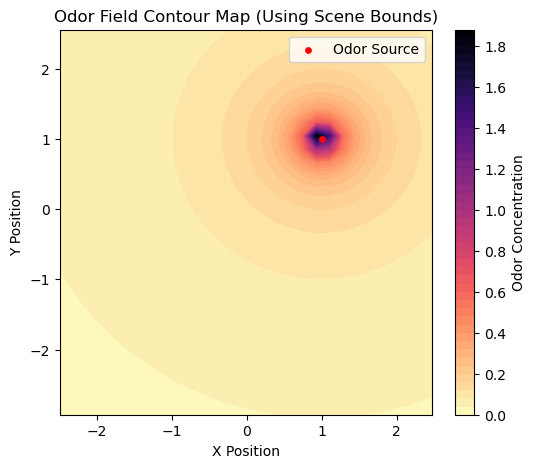

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Scene bounds
min_x, max_x = -2.50, 2.47
min_z, max_z = -2.93, 2.56

# Resolution / number of steps in each dimension
grid_steps = 30

# Define the grid over scene bounds
X = np.linspace(min_x, max_x, grid_steps)
Y = np.linspace(min_z, max_z, grid_steps)
X_grid, Y_grid = np.meshgrid(X, Y)  # Create grid for contour plotting

# Odor source location
x_s, y_s = 1,1  # Example: if you have a known offset, you might need to adjust this
# p_s = np.array([x_s, y_s])

# Parameters
q_s = 2000  # Emission rate
D = 1000     # Diffusivity
U = 0       # Wind speed
tau = 1000  # Particle lifetime
del_t = 1   # Time step
psi = 320 * (math.pi / 180)  # Wind direction in radians

# Compute lambda
lambd = math.sqrt((D * tau) / (1 + (tau * U**2) / (4 * D)))

# Initialize field map
base_map = np.zeros((grid_steps, grid_steps))

rmin = 100

# Compute odor concentration values over the grid
# We'll iterate over index rather than directly over the coordinate arrays
for j in range(grid_steps):
    for i in range(grid_steps):
        x = X[i]
        y = Y[j]
        
        del_y = -(x - x_s) * math.sin(psi) + (y - y_s) * math.cos(psi)
        r = math.dist([x, y], [x_s, y_s])  # Euclidean distance
        
        if r < rmin: rmin=r

        try:
            m = (q_s / (4 * math.pi * D * r)) * math.exp((-del_y * U) / (2 * D) + (-r / lambd) * del_t)
        except ZeroDivisionError:
            # If r=0 or extremely small
            m = 0
        
        base_map[i, j] = m  # Store value in the matrix

print(rmin)
# Plot the contour map
plt.figure(figsize=(6, 5))
contour = plt.contourf(X_grid, Y_grid, base_map.T, levels=60, cmap='magma_r')
plt.colorbar(contour, label='Odor Concentration')

# Mark the odor source location (if it lies within these bounds)
plt.scatter(x_s, y_s, color='red', s=15, label="Odor Source")

# Title and labels
plt.title('Odor Field Contour Map (Using Scene Bounds)')
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.legend()
plt.show()


# Exploration and Knowledge
## Literature
### POMDP

| Variable          | Description          |
|-------------------|----------------------|
| $\mathcal{S}$     | State space          |
| $\mathcal{A}$     | Action space         |
| $\mathcal{O}$     | Observation space    |
| $T(s'|s,a)$       | Transition function  |
| $R(s,a)$          | Reward function      |
| $O(o|s')$         | Observation function |
| $\gamma \in [0,1]$| Discount factor      |



## Graph knowledge

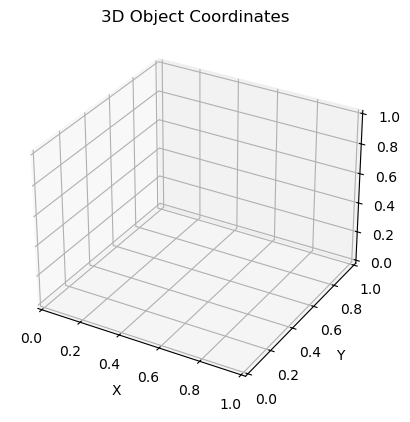

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import time

class Graph3DUpdater:
    def __init__(self):
        # Create an empty NetworkX graph
        self.graph = nx.Graph()
        
        # Set up the 3D plot
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        
        # Set up plot labels and title
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        self.ax.set_zlabel("Z")
        self.ax.set_title("3D Object Coordinates")
        
        # Use interactive mode so updates show immediately.
        plt.ion()
        plt.show()

    def add_object(self, label, coord):
        """
        Adds a new object to the graph and updates the plot.
        
        Parameters:
            label: A unique identifier for the object (string).
            coord: A tuple or list of (x, y, z) coordinates.
        """
        # Add the new node with its coordinate as an attribute.
        self.graph.add_node(label, pos=coord)
        self._update_plot()
        
    def _update_plot(self):
        """Internal method to update the 3D plot from the current graph."""
        # Clear the current plot.
        self.ax.clear()
        
        # Reset labels and title
        self.ax.set_xlabel("X")
        self.ax.set_ylabel("Y")
        self.ax.set_zlabel("Z")
        self.ax.set_title("3D Object Coordinates")
        
        # Get positions from the graph
        positions = nx.get_node_attributes(self.graph, 'pos')
        
        # Plot each node and annotate it.
        for label, pos in positions.items():
            x, y, z = pos
            self.ax.scatter(x, y, z, s=100)
            self.ax.text(x, y, z, f' {label}', fontsize=10)
        
        # Redraw the figure
        plt.draw()
        plt.pause(0.001)  # Small pause to allow the plot to update

# --- Example usage ---
if __name__ == '__main__':
    updater = Graph3DUpdater()
    
    # Initially add some objects.
    updater.add_object("microwave", (-0.237, 1.689, -2.525))
    updater.add_object("oven", (-0.182, 2.112, -2.851))
    
    # Simulate a delay before a new object is learned.
    time.sleep(2)
    
    # Add a new object with its coordinates.
    updater.add_object("chair", (-0.300, 1.500, -2.700))
    
    # Keep the plot open.
    plt.ioff()
    plt.show()


# Plot data

## Robot trajectory

Scene Bounds (X-Z):
  X: -2.50 -> 2.47
  Z: -2.93 -> 2.56
Source Location: (np.float64(-1.6835005283355713), np.float64(2.029001474380493))


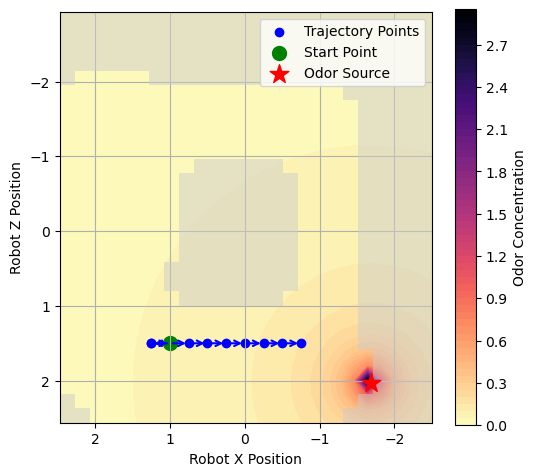

In [94]:

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from skimage.morphology import closing, disk

# -----------------------------
# 1. Compute the Plume Field
# -----------------------------

def get_objects_centers(objects, target_names):
    """
    Filters a list of objects for those whose name contains any of the target names
    and extracts their center x and y coordinates as a NumPy array.
    
    The center is taken from the object's 'axisAlignedBoundingBox' field if available,
    otherwise from the object's 'position'.
    
    Parameters:
        objects (list): A list of dictionaries representing scene objects.
        target_names (list): A list of strings representing substrings to match in the object name.
                             For example: ["Apple", "Bread"]
        
    Returns:
        np.ndarray: A tensor of shape (n, 2) where each row contains the [x, y]
                    coordinates of a matching object.
    """
    centers = []
    
    for obj in objects:
        name = obj.get("name", "")
        # Check if any of the target substrings is in the object's name
        if any(target in name for target in target_names):
            # Prefer the center from axisAlignedBoundingBox if available; otherwise, use the object's position.
            center = obj.get("axisAlignedBoundingBox", {}).get("center", obj.get("position"))
            
            if center is not None and "x" in center and "y" in center and "z" in center:
                centers.append([center["x"], center["y"], center["z"]])
            else:
                print(f"Center coordinates not available for object: {name}")
                
    return np.array(centers)

# -----------------------------
# Obtain Scene Bounds
# -----------------------------
scene_bounds = controller.last_event.metadata["sceneBounds"]
corner_points = scene_bounds['cornerPoints']  # each point is [x, y, z]
unique_xz_points = [(p[0], p[2]) for p in corner_points]
scene_polygon = Polygon(unique_xz_points)
min_x, min_z, max_x, max_z = scene_polygon.bounds

print("Scene Bounds (X-Z):")
print(f"  X: {min_x:.2f} -> {max_x:.2f}")
print(f"  Z: {min_z:.2f} -> {max_z:.2f}")

# -----------------------------
# 2. Define Grid & Compute Plume Field
# -----------------------------
grid_steps = 30  # Adjust resolution as needed
# Define the grid over scene bounds
X = np.linspace(min_x, max_x, grid_steps)
Y = np.linspace(min_z, max_z, grid_steps)
X_grid, Y_grid = np.meshgrid(X, Y)  # Create grid for contour plotting

objects = controller.last_event.metadata["objects"]
odor_items = ["GarbageCan"]  # example
# odor_items = ["Microwave"]  # example

odor_sources = get_objects_centers(objects, odor_items)
odor_x, odor_y, odor_z = odor_sources[0]

if odor_items == ["Microwave"]:
    odor_z += 0.5
elif odor_items == ["GarbageCan"]:
    odor_x += 0.25
    
print(f"Source Location: {odor_x, odor_z}")
# Compute the plume field
# Parameters
q_s = 2000  # Emission rate
D = 1000     # Diffusivity
U = 0       # Wind speed
tau = 1000  # Particle lifetime
del_t = 1   # Time step
psi = 320 * (math.pi / 180)  # Wind direction in radians

# Compute lambda
lambd = math.sqrt((D * tau) / (1 + (tau * U**2) / (4 * D)))

# Initialize field map
base_map = np.zeros((grid_steps, grid_steps))

rmin = 100

# Compute odor concentration values over the grid
# We'll iterate over index rather than directly over the coordinate arrays
for j in range(grid_steps):
    for i in range(grid_steps):
        x = X[i]
        y = Y[j]
        
        del_y = -(x - odor_x) * math.sin(psi) + (y - odor_z) * math.cos(psi)
        r = math.dist([x, y], [odor_x, odor_z])  # Euclidean distance
        
        if r < rmin: rmin=r

        try:
            m = (q_s / (4 * math.pi * D * r)) * math.exp((-del_y * U) / (2 * D) + (-r / lambd) * del_t)
        except ZeroDivisionError:
            # If r=0 or extremely small
            m = 0
        
        base_map[i, j] = m  # Store value in the matrix

# -----------------------------
# 3. Plot the Robot Trajectory
# -----------------------------
# path = "Agent/save/SampleRuns_20-2-25/Fusion/Microwave/InitialPos 1.5,1.5/trajectory_log.csv"
path = "Agent/save/SampleRuns_20-2-25/Fusion/Garbage/InitialPos 1,1.5/trajectory_log.csv"
df = pd.read_csv(path)

reachable = controller.step(action="GetReachablePositions").metadata["actionReturn"]
reach_x = np.array([pos["x"] for pos in reachable])
reach_z = np.array([pos["z"] for pos in reachable])

# Create a grid for reachable areas
resolution = 0.2
x_grid = np.arange(min_x, max_x, resolution)
z_grid = np.arange(min_z, max_z, resolution)
X, Z = np.meshgrid(x_grid, z_grid)

# Build a binary mask for reachable areas
mask = np.zeros(X.shape, dtype=bool)
threshold = resolution * 1.5

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        dists = np.sqrt((reach_x - X[i, j])**2 + (reach_z - Z[i, j])**2)
        if np.any(dists < threshold):
            mask[i, j] = True

# Smooth the mask
mask_closed = closing(mask, disk(1))
alpha_mask = (~mask_closed).astype(float)

# -----------------------------
# 4. Combine the Layers, Using a Contour Map for the Plume
# -----------------------------
plt.figure(figsize=(6, 6))

# (A) Plot the odor field as a contour map (instead of imshow)
contour = plt.contourf(X_grid, Y_grid, base_map.T, levels=60, cmap='magma_r', zorder=1)
plt.colorbar(contour, label='Odor Concentration', shrink=0.9)

# (B) Overlay the grey mask for non-reachable areas
grey = np.array([0.8, 0.8, 0.8, 1.0])
overlay = np.tile(grey, mask.shape + (1,))
overlay[..., 3] = alpha_mask
plt.imshow(overlay, extent=[min_x, max_x, min_z, max_z], origin="lower", zorder=2, alpha=0.5)

# (C) Plot the robot trajectory
plt.scatter(df['robot x'], df['robot z'], color='blue', marker='o', label="Trajectory Points")
for i in range(1, len(df)):
    x_start = df['robot x'].iloc[i-1]
    z_start = df['robot z'].iloc[i-1]
    x_end = df['robot x'].iloc[i]
    z_end = df['robot z'].iloc[i]
    plt.annotate("",
                 xy=(x_end, z_end), xycoords='data',
                 xytext=(x_start, z_start), textcoords='data',
                 arrowprops=dict(arrowstyle="->", color='blue', lw=1.5))

# Mark the starting point
if not df.empty:
    start_x = df['robot x'].iloc[0]
    start_z = df['robot z'].iloc[0]
    plt.scatter(start_x, start_z, color='green', marker='o', s=100, label="Start Point")

# (D) Plot the odor source on the map

plt.scatter(odor_x, odor_z, color='red', marker='*', s=200, label="Odor Source", zorder=3)

# Labeling and axis formatting
plt.xlabel('Robot X Position')
plt.ylabel('Robot Z Position')

plt.xlim(min_x, max_x)
plt.ylim(max_z, min_z)  # Invert Z-axis if desired
plt.gca().invert_xaxis()  # Invert X-axis so negative X is to the right
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()


In [83]:
target_items = ["Microwave"]

# goal = "garbage smell"
# target_items = ["GarbageCan"]


# Obtain current scene objects.
objects = controller.last_event.metadata["objects"]
x_s, y_s, z_s = get_objects_centers(objects, target_items)[0]
z_s += 0.5
sourcePos = np.array([x_s, y_s, z_s])
sourcePos


array([   -0.23643,      1.8658,     -2.0106])

In [85]:
x = -1.0
z = -1.5
dist = np.sqrt((x-x_s)**2+(z-z_s)**2)
dist

np.float64(0.9185523353747246)

In [3]:
controller = Controller(
    agentMode="default",
    visibilityDistance=1.5,
    scene="FloorPlan1",
    gridSize=0.25,
    snapToGrid=True,
    rotateStepDegrees=90,
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    width=300,
    height=300,
    fieldOfView=90
)


In [17]:
controller.step(
    action="Teleport",
    position=dict(x=-0.75, y=0.9, z=-1.5),
    rotation=dict(x=0, y=0, z=0),
)

# controller.step(
#     "MoveAhead",
#     moveMagnitude=0.01
# )

<ai2thor.server.Event at 0x7190940ffe30
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

0.47855753


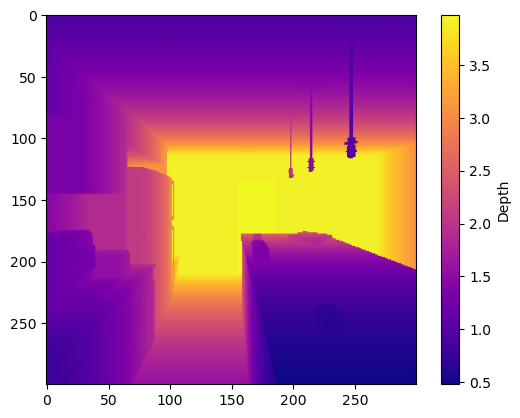

In [18]:
depth_frame = controller.last_event.depth_frame
forward_region = depth_frame[280:300, 50:250]  # central region for forward.
forward_min = np.min(forward_region)
plt.imshow(np.array(depth_frame), cmap='plasma')
plt.colorbar(label='Depth')
print(forward_min)
plt.show()
